# Import package

In [24]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) #show all of columns name on pandas dataframe
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean, std 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# The Lasso and boosting for regression

## Pre-processing data

### Split data into training dan test set

In [14]:
col_list=[]
with open("communities.names", "r") as file:
    for line in file.readlines():
        if line.startswith('@attribute'):
            line=line.split()[1]
            col_list.append(line)
df = pd.read_csv("communities.data", header = None,names=col_list)
training=df[:1495]
test=df[1495:]
test

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,6,?,?,MillValleycity,8,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,0.02,1.0,0.73,0.48,0.31,0.85,0.37,0.12,0.49,0.83,1.00,1.00,0.72,0.48,0.41,0.11,0.96,0.00,0.07,0.04,0.03,0.98,0.11,0.65,0.11,0.73,0.04,0.99,0.75,0.43,0.90,0.88,0.24,0.60,0.70,0.83,0.42,0.61,0.57,0.00,0.21,0.01,0.18,0.18,0.24,0.27,0.14,0.12,0.15,0.15,0.86,0.03,0.09,0.06,0.21,0.27,0.13,0.63,0.05,0.51,0.5,0.01,0.91,0.58,0.00,0.27,0.35,0.01,0.00,1.00,1.00,1.00,0.78,0.87,1.00,0.85,0.83,0.82,0.29,0.00,0.00,0.33,0.45,0.57,0.56,0.74,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.23,0.73,?,?,?,?,0.00,?,0.12
1496,48,?,?,LiveOakcity,8,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,0.02,1.0,0.40,0.87,0.37,0.52,0.14,0.07,0.81,0.36,0.28,0.28,0.33,0.33,0.25,0.25,0.31,0.00,0.14,0.12,0.11,0.33,0.24,0.74,0.11,0.39,0.20,0.48,0.48,0.26,0.54,0.53,0.55,0.76,0.77,0.78,0.75,0.70,0.72,0.00,0.06,0.00,0.27,0.22,0.26,0.34,0.11,0.08,0.08,0.10,0.73,0.08,0.18,0.20,0.61,0.62,0.57,0.59,0.14,0.19,0.5,0.01,0.83,0.59,0.00,0.60,0.79,0.07,0.00,0.13,0.11,0.09,0.33,0.34,0.36,0.36,0.21,0.41,0.94,0.00,0.00,0.17,0.45,0.52,0.59,0.57,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.18,0.02,?,?,?,?,0.00,?,0.11
1497,35,?,?,Portalescity,8,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,0.00,0.0,0.08,0.42,0.78,0.35,0.61,0.75,0.41,0.08,0.11,0.14,0.13,0.17,0.13,0.15,0.17,0.03,0.94,0.64,0.67,0.33,0.65,0.28,0.11,0.84,0.36,0.39,0.43,0.67,0.53,0.51,0.49,0.44,0.44,0.68,0.06,0.17,0.26,0.00,0.18,0.00,0.44,0.61,0.75,0.74,0.20,0.24,0.28,0.25,0.54,0.25,0.35,0.29,0.40,0.42,0.39,0.48,0.29,0.60,0.0,0.02,0.55,0.48,0.15,0.61,0.46,1.00,0.39,0.04,0.04,0.06,0.11,0.12,0.11,0.09,0.62,0.32,0.39,0.00,0.00,0.19,0.47,0.37,0.38,0.49,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.18,0.00,?,?,?,?,0.00,?,0.12
1498,42,17,25112,Fallstownship,8,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,0.06,1.0,0.47,0.72,0.14,0.52,0.44,0.19,0.62,0.45,0.35,0.34,0.40,0.43,0.34,0.27,0.49,0.01,0.10,0.15,0.29,0.22,0.25,0.66,0.48,0.35,0.44,0.31,0.39,0.37,0.41,0.41,0.54,0.74,0.75,0.84,0.68,0.57,0.63,0.01,0.13,0.01,0.24,0.31,0.32,0.33,0.06,0.07,0.06,0.06,0.92,0.04,0.24,0.25,0.56,0.62,0.32,0.79,0.08,0.40,0.5,0.04,0.78,0.74,0.13,0.47,0.42,0.04,0.10,0.28,0.25,0.23,0.59,0.55,0.55,0.54,0.41,0.52,0.44,0.00,0.00,0.10,0.62,0.70,0.75,0.64,?,?,?,?,?,?,?,?,?,?

### deal with the missing values;ignore non-predictive features

In [15]:
# replace the '?' using None
test.replace({"?" : None},inplace = True)
training.replace({"?" : None},inplace = True)

# Statistical missing value
test.isnull().sum().sort_values(ascending = False)
training.isnull().sum().sort_values(ascending=False)

#ignore non-predictive features
training_set=training.drop(["LemasSwFTFieldOps", "PctPolicAsian", "PolicBudgPerPop",
                          "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldPerPop",
                          "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
                          "PolicPerPop", "PctPolicWhite", "PctPolicBlack",
                          "PctPolicHisp", "RacialMatchCommPol", "PctPolicMinor", 
                          "PolicCars", "LemasGangUnitDeploy", "OfficAssgnDrugUnits",
                          "PolicOperBudg", "LemasPctPolicOnPatr", "PolicAveOTWorked",
                          "NumKindsDrugsSeiz", "community", "county", 
                          "state", "communityname", "fold"], axis = 1)
test_set=test.drop(["LemasSwFTFieldOps", "PctPolicAsian", "PolicBudgPerPop",
                        "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldPerPop",
                        "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
                        "PolicPerPop", "PctPolicWhite", "PctPolicBlack",
                        "PctPolicHisp", "RacialMatchCommPol", "PctPolicMinor", 
                        "PolicCars", "LemasGangUnitDeploy", "OfficAssgnDrugUnits",
                        "PolicOperBudg", "LemasPctPolicOnPatr", "PolicAveOTWorked",
                        "NumKindsDrugsSeiz", "community", "county", 
                        "state", "communityname", "fold"], axis = 1)

#Fill in the missing values with averages
training_set = training_set.fillna(value = df["OtherPerCap"].astype("float").mean())
training_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.00,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.00,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.00,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,0.20,0.21,0.51,0.91,0.91,0.89,0.85,0.40,0.60,0.00,0.06,0.00,0.03,0.07,0.20,0.27,0.01,0.02,0.04,0.05,0.88,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.00,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### plot correlation matrix

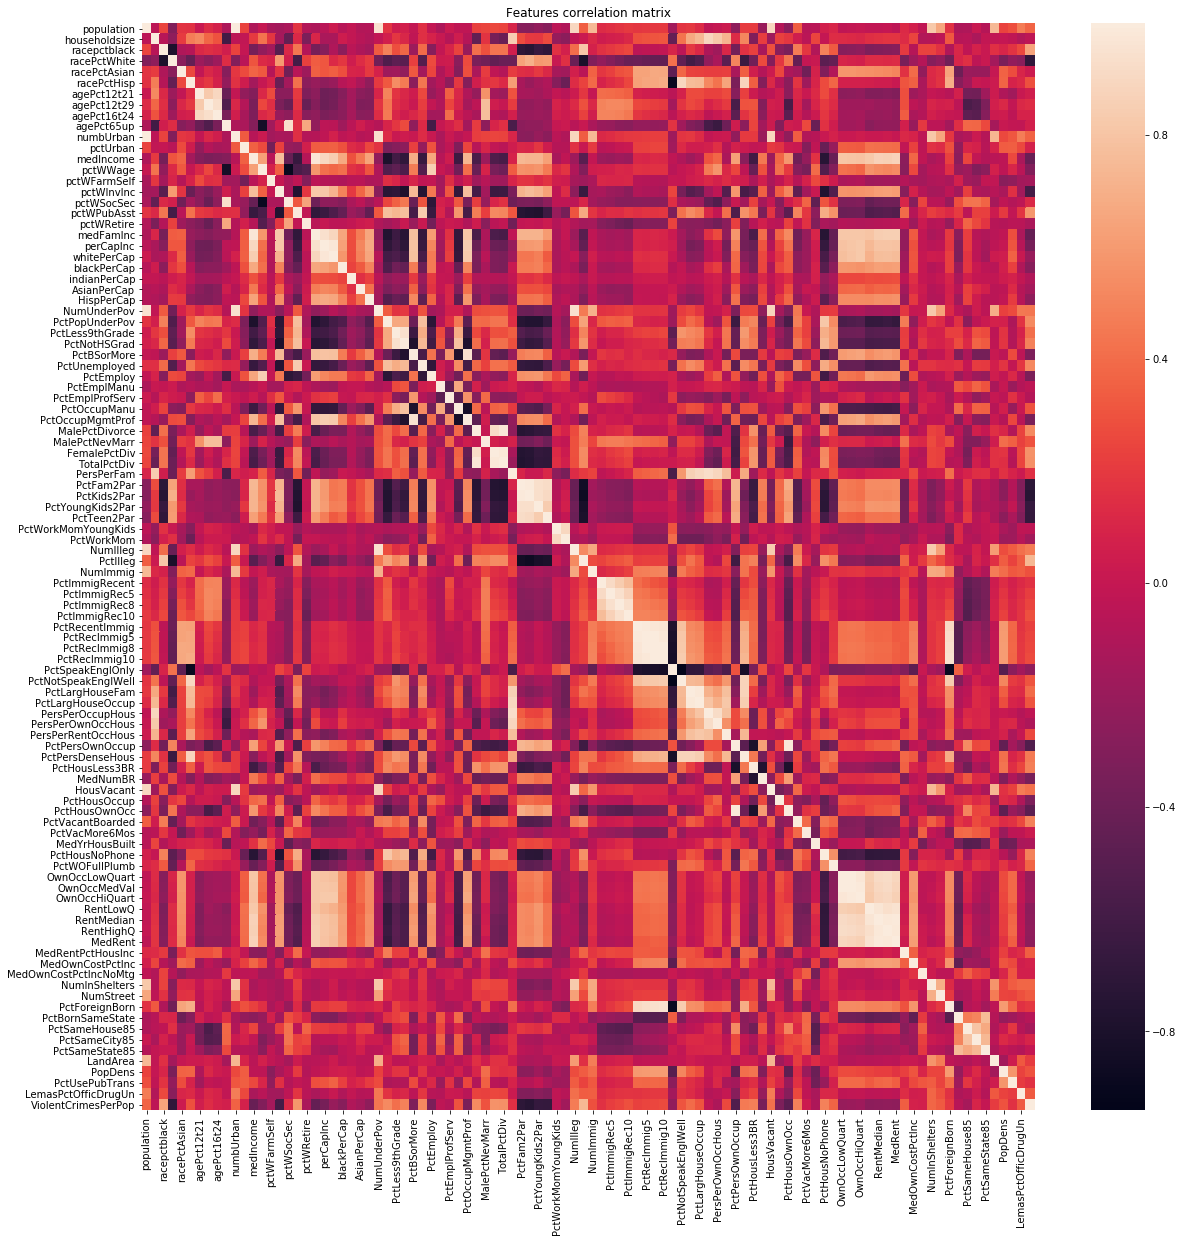

In [16]:
correlation = training_set.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation)
ax.set_title('Features correlation matrix')
plt.show()

### calculate the Coefficient of Variation V for each fatures

In [17]:
CV=std(training_set)/mean(training_set)  
CV

population             2.240355
householdsize          0.355681
racepctblack           1.428407
racePctWhite           0.330102
racePctAsian           1.358645
                         ...   
LandArea               1.644857
PopDens                0.864210
PctUsePubTrans         1.396642
LemasPctOfficDrugUn    2.552092
ViolentCrimesPerPop    0.987578
Length: 100, dtype: float64

### Pick 128**0.5 features with highest CV , and make scatter plots and box plots 

In [18]:
#if we use sorted(),will change the format to list
highest_CV=CV.sort_values(ascending = False)[:round(128**0.5)]
highest_CV

NumStreet              4.291487
NumInShelters          3.469791
NumIlleg               3.057941
NumImmig               2.925656
LemasPctOfficDrugUn    2.552092
NumUnderPov            2.341660
population             2.240355
numbUrban              2.037780
HousVacant             1.967809
LandArea               1.644857
racePctHisp            1.611552
dtype: float64

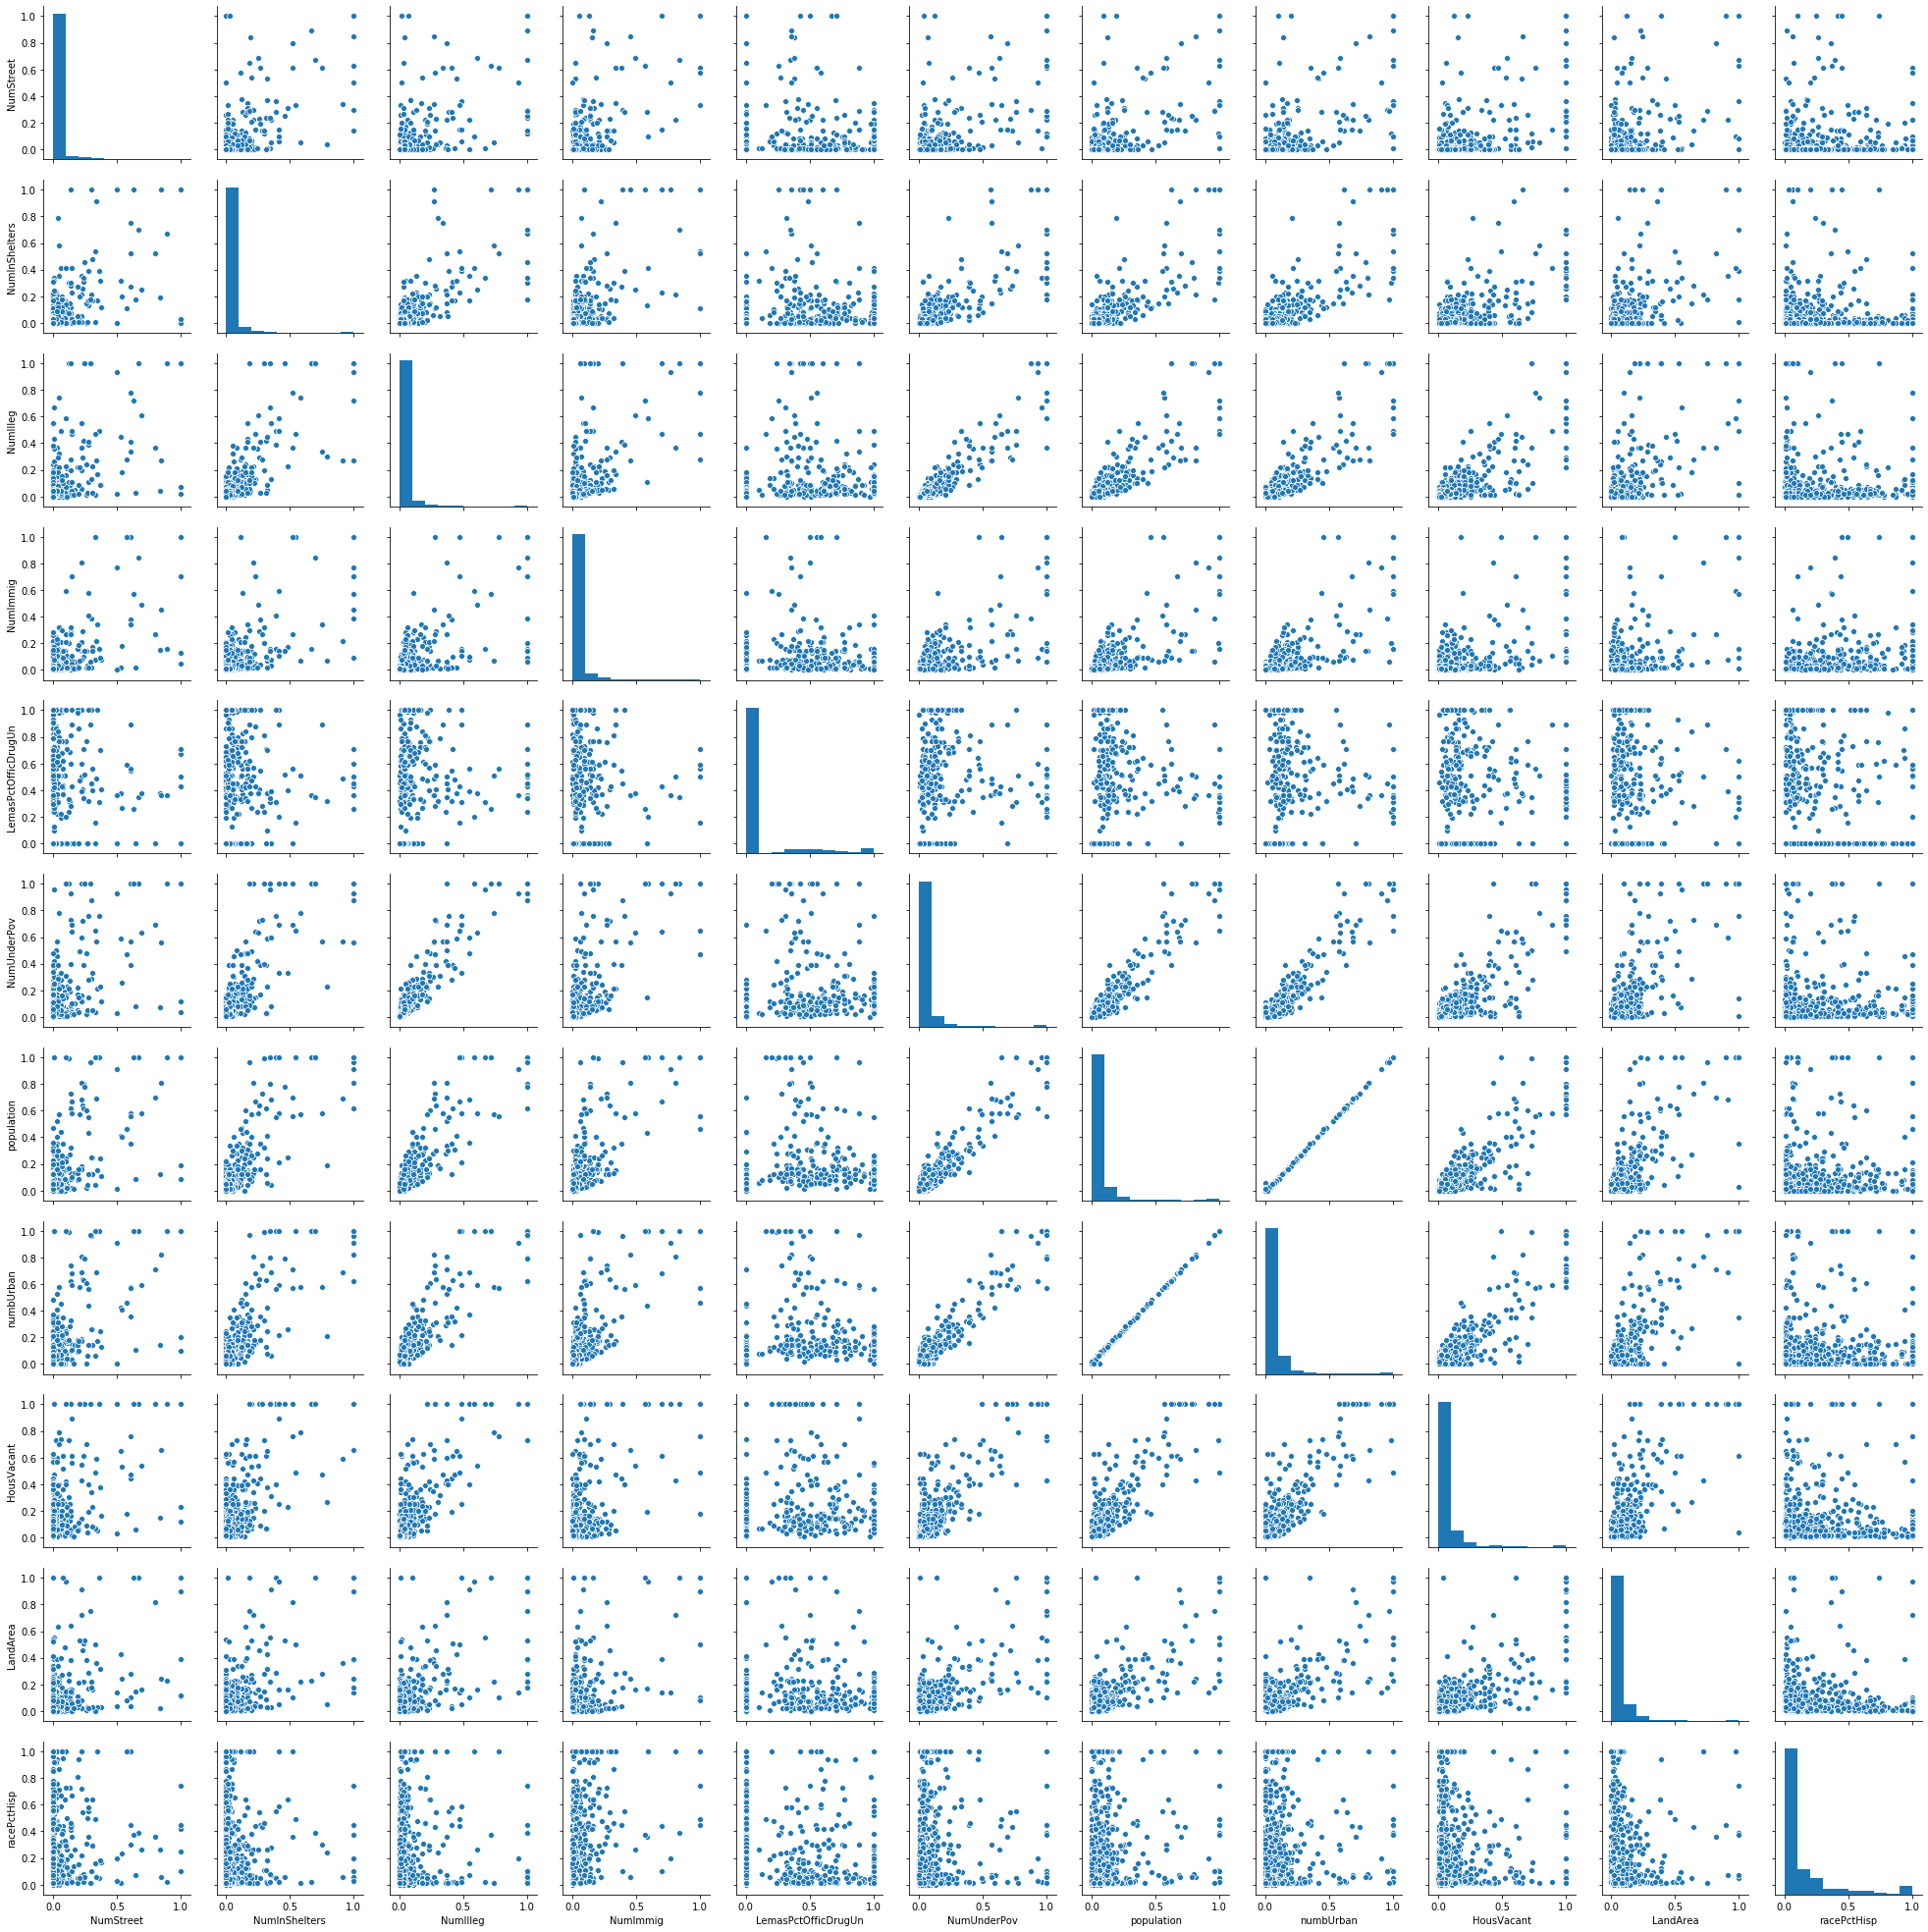

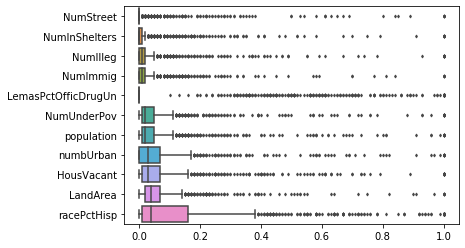

In [19]:
# scatter plots
feature=highest_CV.index.tolist()
new_training=training_set[feature]
sns.pairplot(new_training)
plt.show()

# box plots
sns.boxplot(data=new_training,orient="h",fliersize=2) 
plt.show()

<font color=black size=4 face=雅黑>Answer: From the scatter plot we can see that, some features have strong positive relationship, especially, 'popultion' and 'numbUrban', they have strong positive linear relationship</font>

## Fit model

### fit linear model using least squares and report test error

In [20]:
x_train = training_set.iloc[:,:-1]
x_test = test_set.iloc[:,:-1]
y_train = training_set.iloc[:,-1]
y_test = test_set.iloc[:,-1]

#fit model and report test error
regr = LinearRegression()
model=regr.fit(x_train,y_train)
y_predict=model.predict(x_test)
test_error = mean_squared_error(y_test, y_predict)
print('test error:',test_error)

test error: 0.017844644706157826


### fit ridge regression model and report test error

In [21]:
ridge=RidgeCV()
model=ridge.fit(x_train,y_train)
y_predict=model.predict(x_test)
test_error = mean_squared_error(y_test, y_predict)
print('test error:',test_error)
print('best alpha:',model.alpha_)

test error: 0.017502306931088382
best alpha: 1.0


### fit Lasso model and report test error

In [22]:
lasso=LassoCV() 
model=lasso.fit(x_train,y_train)
y_predict=model.predict(x_test)
test_error = mean_squared_error(y_test, y_predict)
print('test error:',test_error)
print('best alpha:',model.alpha_)

test error: 0.017569740293820257
best alpha: 0.00011614723626829846


In [23]:
# standarlize features
scaler = StandardScaler()
model=scaler.fit(training_set)
tr=model.transform(training_set)
std_training_set=pd.DataFrame(tr)

model=scaler.fit(test_set)
te=model.transform(test_set)
std_test_set=pd.DataFrame(te)

#extract training and test
std_x_train = std_training_set.iloc[:,:-1]
std_x_test = std_test_set.iloc[:,:-1]
std_y_train = std_training_set.iloc[:,-1]
std_y_test = std_test_set.iloc[:,-1]

model=lasso.fit(std_x_train,std_y_train)
y_predict=model.predict(std_x_test)
test_error = mean_squared_error(std_y_test, y_predict)
print('test error:',test_error)
print('best alpha:',model.alpha_)

test error: 0.36422443559439865
best alpha: 0.002793077812848564


<font color=black size=4 face=雅黑>Answer: After standarlize features, the test error is increase, so the original data is better to predict</font>

### fit PCR model and report test error

In [13]:
best_score, best_num_comp = 0, 1
for n_comp in range(1, len(x_train.columns)+1):
    pca = PCA(n_components=n_comp)
    
    # PCA
    reduced_x_train = pca.fit_transform(x_train)
    reduced_x_test = pca.transform(x_test) 

    # cross validation
    lm = LinearRegression()
    score = np.mean(cross_val_score(lm, reduced_x_train, y_train, cv = 5)) #the accuracy of cross-validation
    # compare performace
    if best_score < score:
        best_score = score
        best_num_comp = n_comp

pca = PCA(n_components = best_num_comp)
reduced_x_train = pca.fit_transform(x_train)
reduced_x_test = pca.transform(x_test) 

model=lm.fit(reduced_x_train, y_train)
y_predict = model.predict(reduced_x_test)
test_error = mean_squared_error(y_test, y_predict)
print('test error:',test_error)

test error: 0.01806315945884325


### fit bootsting tree

In [14]:
# store data in a DMatrix object
dtrain = xgb.DMatrix(np.array(x_train), label = np.array(y_train))
dtest = xgb.DMatrix(np.array(x_test), label = np.array(y_test))

#Setting Parameters
best_error=100
best_alph=0
alpha_ls = [0, 0.1, 0.5, 1, 10, 100]
for i in alpha_ls:
    param = {"reg_alpha":i}
    bst = xgb.train(param, dtrain)
    # make prediction
    y_predict= bst.predict(dtest)
    test_error = mean_squared_error(y_test, y_predict)
    if best_error > test_error:
        best_error = test_error
        best_alpha = i
print("best alpha:",best_alpha)

best alpha: 1
